In [ ]:
%%capture
!pip install datasets
!pip install optuna

In [ ]:
# The value for the seed and paths
SEED = 168
PATH_TO_W2V_MODEL_DRIVE = '/content/drive/My Drive/NLP Project/GoogleNews-vectors-negative300.bin'
PATH_TO_W2V_MODEL_LOCAL = r'GoogleNews-vectors-negative300.bin'
PATH_TO_FASTTEXT_MODEL_DRIVE = '/content/drive/My Drive/NLP Project/cc.en.300.bin'
PATH_TO_FASTTEXT_MODEL_LOCAL = r'cc.en.300.bin/cc.en.300.bin'

In [ ]:
# Standard library imports
from collections import Counter

# General third-party libraries import
import copy
from gensim.models import KeyedVectors
from gensim.models.fasttext import load_facebook_model
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import sys

# Import optuna for hyperparams tuning
import optuna

# Import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary nltk resources
nltk.download('wordnet')
nltk.download('punkt')  # Ensure punkt is downloaded for tokenization
nltk.download('stopwords')  # Ensure stopwords are also downloaded if not already

# Import pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.nn.utils.rnn import pad_sequence

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Method to set random seed to ensure consistency
def set_seed(seed = SEED):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

# Factory to create the dataloader
def dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device):
    # Create Tensor datasets
    train_dataset = TensorDataset(X_train_sequence.to(device), torch.tensor(Y_train, dtype=torch.long, device=device))
    val_dataset = TensorDataset(X_val_sequence.to(device), torch.tensor(Y_val, dtype=torch.long, device=device))
    test_dataset = TensorDataset(X_test_sequence.to(device), torch.tensor(Y_test, dtype=torch.long, device=device))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=30, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > self.max_validation_accuracy:
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        elif validation_accuracy < (self.max_validation_accuracy + self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Factory to provide required optimizer which specified parameters
def optimizer_factory(optimizer_name, model, learning_rate, momentum = 0.8):
    if optimizer_name == 'Adam':
        return torch.optim.Adam(model.parameters(), lr = learning_rate)
    if optimizer_name == 'SGD':
        return torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)
    if optimizer_name == 'RMSprop':
        return torch.optim.RMSprop(model.parameters(), lr = learning_rate)

# Method to train the model
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()  # Set model to training mode
    train_loss = 0  # To accumulate loss for this epoch

    for inputs, labels in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass

        # Calculate loss
        loss = loss_fn(outputs.squeeze(), labels.float())  # Squeeze to match dimensions
        loss.backward()  # Backpropagation

        # # Apply gradient clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()  # Update parameters

        train_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the epoch
    train_loss /= len(dataloader)
    return train_loss

# Method to evaluate the model
def test_loop(dataloader, model):
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            outputs = model(inputs)  # Forward pass
            predicted = (outputs.squeeze() > 0.5).float()  # Apply threshold

            total += labels.size(0)
            correct += (predicted == labels.float()).sum().item()  # Count correct predictions

    accuracy = correct / total
    return accuracy

# Method to plot the performance graph
def plot_performance(train_losses, val_accuracies, num_epochs):
    # Visualization
    plt.figure(figsize=(12, 5))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_epochs + 1, 10))
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, num_epochs + 1, 10))
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Part 0. Dataset Preparation**

Part 0. Dataset Preparation We will be using the movie review dataset introduced in https://www.cs.cornell.edu/people/ pabo/movie-review-data/rt-polaritydata.README.1.0.txt. To load this dataset, you need to install the “datasets” library via pip install datasets. Then you can use the following code snippet: 1 from datasets import load_dataset 2 dataset = load_dataset (" rotten_tomatoes ") 3 train_dataset = dataset [’train ’] 4 validation_dataset = dataset [’validation ’] 5 test_dataset = dataset [’test ’] Using the original train-valid-test split provided in the above code, you will perform model training on the training dataset, configure your model (e.g., learning rate, batch size, number of training epochs) on the validation dataset, and conduct evaluation on the test dataset.

# **Load Dataset**

In [ ]:
set_seed()
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
print(f"train_dataset size: {len(train_dataset)}")
print(f"validation_dataset size: {len(validation_dataset)}")
print(f"test_dataset size: {len(test_dataset)}")
print(f"data format: {train_dataset[0]}")

train_dataset size: 8530
validation_dataset size: 1066
test_dataset size: 1066
data format: {'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


In [ ]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"The name of the CUDA device is: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!
The name of the CUDA device is: Tesla T4


# **Load word2vec Model**

In [ ]:
# Load the pre-trained Word2Vec model
if 'google.colab' in sys.modules:
    print("Running on Google Colab's hosted runtime")
    from google.colab import drive
    drive.mount('/content/drive')
    w2v_model = KeyedVectors.load_word2vec_format(PATH_TO_W2V_MODEL_DRIVE, binary=True)
else:
    print("Running on a local runtime")
    w2v_model = KeyedVectors.load_word2vec_format(PATH_TO_W2V_MODEL_LOCAL, binary=True)

# Get the dimension of the embeddings
vector_dim = w2v_model.vector_size
print(f"Word2Vec Dimension: {vector_dim}")


Running on Google Colab's hosted runtime
Mounted at /content/drive
Word2Vec Dimension: 300


# **Data Preprocessing**

In [ ]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

# Dataset Preprocessing to tokenize and/or lemmatize
def preprocess_dataset(data, lemmatization = True):
    processed_sentences = []

    for entry in data:
        text = entry['text']
        # Tokenize the sentence
        tokens = word_tokenize(text)
        if lemmatization:
          # With case folding, punctuation and stop words removal
          tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in punctuation]# and word.lower() not in stop_words]

        processed_sentences.append(tokens)

    return processed_sentences

# Get vocab and oov words
def get_vocab_OOV(sentences, w2v_model):
    vocabulary = set()
    oov_words = set()

    for sentence in sentences:
        for word in sentence:
            vocabulary.add(word)
            if word not in w2v_model:
                oov_words.add(word)

    return vocabulary, oov_words

vocabulary, oov_words = get_vocab_OOV(preprocess_dataset(train_dataset, False), w2v_model)
lemmatized_vocabulary, lemmatized_oov_words = get_vocab_OOV(preprocess_dataset(train_dataset), w2v_model)

print(f"Before lemmatization: Vocabulary size: {len(vocabulary)}, OOV words: {len(oov_words)}")
print(f"After lemmatization: Vocabulary size: {len(lemmatized_vocabulary)}, OOV words: {len(lemmatized_oov_words)}")

Before lemmatization: Vocabulary size: 18030, OOV words: 3613
After lemmatization: Vocabulary size: 16565, OOV words: 3584




1.   Lemmatize, case folding and remove stop words for train, validation and test set
2.   Drop words not found in train dataset for validation and test set




In [ ]:
preprocessed_train_dataset = preprocess_dataset(train_dataset)
preprocessed_validation_dataset = preprocess_dataset(validation_dataset)
preprocessed_test_dataset = preprocess_dataset(test_dataset)

In [ ]:
def drop_oov(preprocessed_dataset, w2v_model):
    return [[word for word in sentence if word in w2v_model] for sentence in preprocessed_dataset]

def drop_non_train_vocab(dataset, train_vocab):
    return [[word for word in sentence if word in train_vocab] for sentence in dataset]

#X_train = drop_oov(preprocessed_train_dataset, w2v_model)
X_train = preprocessed_train_dataset
Y_train = [entry['label'] for entry in train_dataset]

#X_val = drop_non_train_vocab(drop_oov(preprocessed_validation_dataset, w2v_model), lemmatized_vocabulary)
X_val = drop_non_train_vocab(preprocessed_validation_dataset, lemmatized_vocabulary)
Y_val = [entry['label'] for entry in validation_dataset]

#X_test = drop_non_train_vocab(drop_oov(preprocessed_test_dataset, w2v_model), lemmatized_vocabulary)
X_test = drop_non_train_vocab(preprocessed_test_dataset, lemmatized_vocabulary)
Y_test = [entry['label'] for entry in test_dataset]


In [ ]:
print(train_dataset['label'])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Sanity check: If preprocessed data is wrong

In [ ]:
print(f"X_train size: {len(X_train)}")
print(f"Y_train size: {len(Y_train)}")

print(f"X_val size: {len(X_val)}")
print(f"Y_val size: {len(Y_val)}")

print(f"X_test size: {len(X_test)}")
print(f"Y_test size: {len(Y_test)}")

X_train size: 8530
Y_train size: 8530
X_val size: 1066
Y_val size: 1066
X_test size: 1066
Y_test size: 1066


# **Generate Embedding**

In [ ]:
def get_word2index(train_vocab):
    word2index = {}
    for idx, word in enumerate(train_vocab):
        word2index[word] = idx + 1  # +1 to offset 0 for padding
    return word2index

word2index = get_word2index(lemmatized_vocabulary)

In [ ]:
print(f"word2index size = vocab size: {len(word2index)}")

word2index size = vocab size: 16565


#Statistical Normal Distribution for Embedding Matrix

In [ ]:
def create_embedding_matrix(w2v_model, word2index, embedding_dim=300):
    """
    Creates an embedding matrix based on the word2index mapping and Word2Vec model.

    Args:
    - w2v_model: Pre-trained Word2Vec model.
    - word2index: Dictionary mapping words to their indices.
    - embedding_dim: Dimension of the Word2Vec word vectors (default: 300).

    Returns:
    - embedding_matrix: Embedding matrix where each row corresponds to the vector of a word in the vocabulary.
    """

    mean = np.mean(w2v_model.vectors, axis=0)
    std = np.std(w2v_model.vectors, axis=0)


    vocab_size = len(word2index)  # Number of words in the training vocabulary

    # Initialize the embedding matrix with zeros (or any other value)
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
    num_oov = 0

    for word, idx in word2index.items():
        if word in w2v_model:
            # If the word exists in the Word2Vec model, use its pre-trained embedding
            embedding_matrix[idx] = w2v_model[word]
        else:
            num_oov += 1
            embedding_matrix[idx] = np.random.normal(
                loc=mean, scale=std, size=(embedding_dim,)
            )

    return embedding_matrix

embedding_dim = w2v_model.vector_size  # Get the dimension of the word vectors in Word2Vec
embedding_matrix = create_embedding_matrix(w2v_model, word2index, embedding_dim)
print(f"embedding_matrix shape: {embedding_matrix.shape}")

embedding_matrix shape: (16566, 300)


# **Sentence2sequence + Padding**

In [ ]:
# Get maximum sentence length
def get_max_sentence_length(*datasets):
    """
    Get the maximum sentence length from the provided datasets.

    Args:
    - datasets: A variable number of lists containing tokenized sentences.

    Returns:
    - max_length: The maximum sentence length across all datasets.
    """
    max_length = 0
    for index, dataset in enumerate(datasets):
        # Update max_length if a longer sentence is found
        max_length = max(max_length, max(len(sentence) for sentence in dataset))
        min_length = min(len(sentence) for sentence in dataset)
        print(f"Min sentence length in dataset {index}: {min_length}")
    return max_length

# Example usage
max_length = get_max_sentence_length(X_train, X_val, X_test)
print(f"Maximum sentence length of three datasets: {max_length}")

Min sentence length in dataset 0: 1
Min sentence length in dataset 1: 0
Min sentence length in dataset 2: 1
Maximum sentence length of three datasets: 53


In [ ]:
def convert_to_sequence_data(tokenized_data, word2index, max_length=max_length):
    """
    Preprocess the tokenized data for RNN input.

    Args:
    - tokenized_data: List of tokenized sentences.
    - word2index: Dictionary mapping words to indices.
    - max_length: Maximum length for padding (default is 100).

    Returns:
    - padded_sequences: Padded tensor of sequences.
    """
    # Convert tokens to indices
    indexed_sequences = []
    for sentence in tokenized_data:
        indexed_sentence = [word2index.get(word, 0) for word in sentence]  # Use 0 for OOV words

        # Truncate or pad the indexed sentence to the specified max_length
        if len(indexed_sentence) > max_length:
            indexed_sentence = indexed_sentence[:max_length]  # Truncate
        else:
            indexed_sentence += [0] * (max_length - len(indexed_sentence))  # Pad with zeros

        indexed_sequences.append(torch.tensor(indexed_sentence, dtype=torch.long))

    # Convert list of tensors to a padded tensor
    padded_sequences = torch.stack(indexed_sequences)

    return padded_sequences

# Convert to sequence
X_train_sequence = convert_to_sequence_data(X_train, word2index)
X_val_sequence = convert_to_sequence_data(X_val , word2index)
X_test_sequence = convert_to_sequence_data(X_test, word2index)


Sanity check: if the sequenced tokens mapped correctly to embedding matrix and w2v_model

In [ ]:
# Check if the sequenced tokens mapped correctly to embedding matrix and w2v_model
embedding_matrix[X_train_sequence[0][0]] == w2v_model[X_train[0][0]]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
print(f"Shape of X_train_sequence: {X_train_sequence.shape}")
print(f"Shape of X_valn_sequence: {X_val_sequence.shape}")
print(f"Shape of X_test_sequence: {X_test_sequence.shape}")

Shape of X_train_sequence: torch.Size([8530, 53])
Shape of X_valn_sequence: torch.Size([1066, 53])
Shape of X_test_sequence: torch.Size([1066, 53])


# Create Tensor datasets
train_dataset = TensorDataset(X_train_sequence, torch.tensor(Y_train, dtype=torch.long))
val_dataset = TensorDataset(X_val_sequence, torch.tensor(Y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_sequence, torch.tensor(Y_test, dtype=torch.long))

# Define the objective function for Optuna
def objective(trial):
    max_accuracy = 0

    # Reset the seed to ensure fairness when comparing performances
    set_seed()

    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])  # Hidden size choices
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # Number of RNN layers choices
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])  # Learning rate choices
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])  # Batch size choices
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])  # num epoch choices
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # Optimizer choices


    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    # Initialize the model
    model = SimpleRNN(embedding_matrix, hidden_size, num_layers)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification
    
    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Lists to store loss and accuracy for visualization
    train_losses = []
    val_accuracies = []

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()  # Set model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in data_loader:
                outputs = model(inputs)  # Forward pass
                predicted = (outputs.squeeze() > 0.5).float()  # Apply threshold

                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()  # Count correct predictions

        accuracy = correct / total
        return accuracy

    # Training Loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0  # To accumulate loss for this epoch

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass

            # Calculate loss
            loss = criterion(outputs.squeeze(), labels.float())  # Squeeze to match dimensions
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters

            epoch_loss += loss.item()  # Accumulate loss

        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on validation set
        val_accuracy = evaluate_model(val_loader)
        val_accuracies.append(val_accuracy)
        if val_accuracy>max_accuracy:
          max_accuracy = val_accuracy

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return max_accuracy  # Return validation accuracy for optimization

# Create a study object for Optuna
study = optuna.create_study(direction='maximize')  # We want to maximize validation accuracy
study.optimize(objective, n_trials=100)  # Run 100 trials

#**Simple BiLSTM Architecture**

In [ ]:
import torch
import torch.nn as nn

class SimpleBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, aggregation='last_hidden_state', freeze_embedding=True):
        super(SimpleBiLSTM, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.aggregation = aggregation
        self.hidden_size = hidden_size  # Store hidden size for reference

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=0,  # Using 0 for padding index
            freeze=freeze_embedding,  # Freeze embeddings
        )

        # BiLSTM layer with bidirectional=True
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)

        # Output layer dimensions adjusted for bidirectional LSTM (2 * hidden_size)
        if self.aggregation == "max_mean_pool":
            self.fc = nn.Linear(4 * hidden_size, 1)  # Output size is 1 for binary classification
        else:
            self.fc = nn.Linear(2 * hidden_size, 1)


    def forward(self, x):
        # Pass through the embedding layer
        embedded = self.embedding(x)

        # Initialize hidden and cell states for both directions (2*num_layers for bidirectional)
        h0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)
        c0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)

        # Forward pass through BiLSTM
        out, (hn, cn) = self.lstm(embedded, (h0, c0))

        # Aggregation method
        if self.aggregation == 'last_hidden_state':
            # Concatenate the last hidden states from both directions
            out = torch.cat((hn[-2], hn[-1]), dim=1)  # -2 and -1 refer to the last forward and backward states
        elif self.aggregation == 'max_pool':
            # Mask out padding tokens for max pooling
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            out = out.masked_fill(~mask, -100000)
            out, _ = torch.max(out, dim=1)
        elif self.aggregation == 'mean_pool':
            # Mask out padding tokens for mean pooling
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            out = out * mask
            summed = out.sum(dim=1)
            valid_counts = mask.sum(dim=1).clamp(min=1)
            out = summed / valid_counts

        elif self.aggregation == 'max_mean_pool':
            # Mask out padding tokens for pooling
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)

            # Max pooling
            max_pooled_out = out.masked_fill(~mask, -100000)  # Mask padding tokens with a large negative value
            max_pooled_out, _ = torch.max(max_pooled_out, dim=1)

            # Mean pooling
            mean_pooled_out = out * mask
            summed = mean_pooled_out.sum(dim=1)
            valid_counts = mask.sum(dim=1).clamp(min=1)
            mean_pooled_out = summed / valid_counts

            # Concatenate max and mean pooling outputs
            out = torch.cat((max_pooled_out, mean_pooled_out), dim=1)

        out = self.dropout(out)  # Apply dropout
        out = self.fc(out)  # Final fully connected layer

        # Sigmoid activation for binary classification
        out = torch.sigmoid(out)

        return out


#**BiLSTM - Word2Vec (MaxPool - Stat Normal)**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation="max_pool",freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
#[I 2024-10-28 02:07:30,333] Trial 15 finished with value: 0.8030018761726079 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.1, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.8030018761726079.

[I 2024-10-28 01:48:12,675] A new study created in memory with name: no-name-6ad44cba-23c3-4295-8442-1956133eca0d
[I 2024-10-28 01:49:23,739] Trial 0 finished with value: 0.775797373358349 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 128, 'num_epochs': 50, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.775797373358349.
[I 2024-10-28 01:49:52,164] Trial 1 finished with value: 0.7861163227016885 and parameters: {'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 10, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.7861163227016885.
[I 2024-10-28 01:50:05,928] Trial 2 finished with value: 0.7129455909943715 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 10, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7861163227016885.
[I 2024-10-28 01:50:47,674] Trial 3 finished with value: 0.575046904315197 and parameters: {'hidden_size

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 2 # Number of RNN layers choices
learning_rate = 0.1  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 60  # num epoch choices
optimizer_name = 'SGD'  # Optimizer choices
#[I 2024-10-28 02:07:30,333] Trial 15 finished with value: 0.8030018761726079 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.1, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'SGD'}. Best is trial 15 with value: 0.8030018761726079.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='max_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    #Early stopping
    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7974

Epoch [1/60], Train Loss: 0.6929, Validation Accuracy: 0.4991
Epoch [2/60], Train Loss: 0.6865, Validation Accuracy: 0.5797
Epoch [3/60], Train Loss: 0.6249, Validation Accuracy: 0.6886
Epoch [4/60], Train Loss: 0.5184, Validation Accuracy: 0.7402
Epoch [5/60], Train Loss: 0.4826, Validation Accuracy: 0.7495
Epoch [6/60], Train Loss: 0.4658, Validation Accuracy: 0.7598
Epoch [7/60], Train Loss: 0.4591, Validation Accuracy: 0.7786
Epoch [8/60], Train Loss: 0.4478, Validation Accuracy: 0.7711
Epoch [9/60], Train Loss: 0.4287, Validation Accuracy: 0.7692
Epoch [10/60], Train Loss: 0.4265, Validation Accuracy: 0.7899
Epoch [11/60], Train Loss: 0.4166, Validation Accuracy: 0.7777
Epoch [12/60], Train Loss: 0.4102, Validation Accuracy: 0.7824
Epoch [13/60], Train Loss: 0.3998, Validation Accuracy: 0.8030
Epoch [14/60], Train Loss: 0.3859, Validation Accuracy: 0.7889
Epoch [15/60], Train Loss: 0.3823, Validation Accuracy: 0.7946
Epoch [16/60], Train Loss: 0.3731, Validation Accuracy: 0.7561
E

#**BiLSTM - Word2Vec (MeanPool - Stat Normal)**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers,freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
#[I 2024-10-28 05:12:08,917] Trial 19 finished with value: 0.7917448405253283 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 19 with value: 0.7917448405253283.

[I 2024-10-28 05:58:41,373] A new study created in memory with name: no-name-0564e1ac-11b6-4250-b76c-2294aca3647e
[I 2024-10-28 05:59:21,760] Trial 0 finished with value: 0.7842401500938087 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.7842401500938087.
[I 2024-10-28 05:59:39,364] Trial 1 finished with value: 0.6529080675422139 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 10, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.7842401500938087.
[I 2024-10-28 06:01:31,378] Trial 2 finished with value: 0.7861163227016885 and parameters: {'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.7861163227016885.
[I 2024-10-28 06:02:23,284] Trial 3 finished with value: 0.7823639774859287 and parameters: {'

In [ ]:
#[I 2024-10-28 05:12:08,917] Trial 19 finished with value: 0.7917448405253283 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 19 with value: 0.7917448405253283.
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 2 # Number of RNN layers choices
learning_rate = 0.0001  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices


In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    #Early stopping
    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7730

Epoch [1/50], Train Loss: 0.5933, Validation Accuracy: 0.7139
Epoch [2/50], Train Loss: 0.4999, Validation Accuracy: 0.7364
Epoch [3/50], Train Loss: 0.4796, Validation Accuracy: 0.7617
Epoch [4/50], Train Loss: 0.4689, Validation Accuracy: 0.7458
Epoch [5/50], Train Loss: 0.4581, Validation Accuracy: 0.7495
Epoch [6/50], Train Loss: 0.4551, Validation Accuracy: 0.7608
Epoch [7/50], Train Loss: 0.4472, Validation Accuracy: 0.7627
Epoch [8/50], Train Loss: 0.4418, Validation Accuracy: 0.7608
Epoch [9/50], Train Loss: 0.4366, Validation Accuracy: 0.7758
Epoch [10/50], Train Loss: 0.4321, Validation Accuracy: 0.7608
Epoch [11/50], Train Loss: 0.4263, Validation Accuracy: 0.7645
Epoch [12/50], Train Loss: 0.4220, Validation Accuracy: 0.7355
Epoch [13/50], Train Loss: 0.4179, Validation Accuracy: 0.7767
Epoch [14/50], Train Loss: 0.4119, Validation Accuracy: 0.7899
Epoch [15/50], Train Loss: 0.4082, Validation Accuracy: 0.7749
Epoch [16/50], Train Loss: 0.4023, Validation Accuracy: 0.7645
E

#**BiLSTM - Word2Vec (LHS - Stat Normal)**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers,freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-10-28 07:38:51,176] Trial 6 finished with value: 0.7926829268292683 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 50, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7926829268292683.

[I 2024-10-29 01:41:20,112] A new study created in memory with name: no-name-ec64ac70-d214-4832-9729-40a23948e006
[I 2024-10-29 01:42:07,480] Trial 0 finished with value: 0.775797373358349 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.1, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.775797373358349.
[I 2024-10-29 01:43:16,494] Trial 1 finished with value: 0.7673545966228893 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.1, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.775797373358349.
[I 2024-10-29 01:44:54,631] Trial 2 finished with value: 0.5 and parameters: {'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.1, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.775797373358349.
[I 2024-10-29 01:46:12,391] Trial 3 finished with value: 0.7833020637898687 and parameters: {'hidden_size': 128, 'num_layers': 2, 'l

In [ ]:
hidden_size = 128  # Hidden size choices
num_layers = 2 # Number of RNN layers choices
learning_rate = 0.001  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'Adam'  # Optimizer choices

#[I 2024-10-28 07:38:51,176] Trial 6 finished with value: 0.7926829268292683 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 50, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.7926829268292683.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers)
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    #Early stopping
    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7833

Epoch [1/50], Train Loss: 0.5748, Validation Accuracy: 0.7580
Epoch [2/50], Train Loss: 0.4762, Validation Accuracy: 0.7523
Epoch [3/50], Train Loss: 0.4509, Validation Accuracy: 0.7758
Epoch [4/50], Train Loss: 0.4283, Validation Accuracy: 0.7842
Epoch [5/50], Train Loss: 0.4113, Validation Accuracy: 0.7852
Epoch [6/50], Train Loss: 0.3887, Validation Accuracy: 0.7908
Epoch [7/50], Train Loss: 0.3601, Validation Accuracy: 0.7786
Epoch [8/50], Train Loss: 0.3353, Validation Accuracy: 0.7758
Epoch [9/50], Train Loss: 0.2949, Validation Accuracy: 0.7889
Epoch [10/50], Train Loss: 0.2668, Validation Accuracy: 0.7824
Epoch [11/50], Train Loss: 0.2231, Validation Accuracy: 0.7814
Epoch [12/50], Train Loss: 0.2009, Validation Accuracy: 0.7833
Epoch [13/50], Train Loss: 0.1650, Validation Accuracy: 0.7720
Epoch [14/50], Train Loss: 0.1393, Validation Accuracy: 0.7786
Epoch [15/50], Train Loss: 0.1128, Validation Accuracy: 0.7664
Epoch [16/50], Train Loss: 0.0886, Validation Accuracy: 0.7795
E

#MaxMean Concatentation (Stat-Normal)


In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers,aggregation='max_mean_pool',freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
#[I 2024-10-31 03:20:33,323] Trial 28 finished with value: 0.799249530956848 and parameters: {'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 40, 'optimizer': 'RMSprop'}. Best is trial 28 with value: 0.799249530956848.

[I 2024-10-31 02:50:52,004] A new study created in memory with name: no-name-c716f8cf-c290-4fde-9ca6-7b8f09ba1e4e
[I 2024-10-31 02:52:06,258] Trial 0 finished with value: 0.7682926829268293 and parameters: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 40, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7682926829268293.
[I 2024-10-31 02:53:18,559] Trial 1 finished with value: 0.7711069418386491 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 128, 'num_epochs': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.7711069418386491.
[I 2024-10-31 02:54:38,366] Trial 2 finished with value: 0.6397748592870544 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 40, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.7711069418386491.
[I 2024-10-31 02:55:20,606] Trial 3 finished with value: 0.7795497185741088 and parameters: {'hidden_size': 

In [ ]:
#[I 2024-10-31 03:20:33,323] Trial 28 finished with value: 0.799249530956848 and parameters: {'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 40, 'optimizer': 'RMSprop'}. Best is trial 28 with value: 0.799249530956848.
# The Best Hyperparameters
hidden_size = 256  # Hidden size choices
num_layers = 2 # Number of RNN layers choices
learning_rate = 0.001  # Learning rate choices
batch_size = 32  # Batch size choices
num_epochs = 40  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='max_mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7852

Epoch [1/40], Train Loss: 0.5278, Validation Accuracy: 0.7871
Epoch [2/40], Train Loss: 0.4313, Validation Accuracy: 0.7852
Epoch [3/40], Train Loss: 0.3939, Validation Accuracy: 0.7936
Epoch [4/40], Train Loss: 0.3435, Validation Accuracy: 0.7917
Epoch [5/40], Train Loss: 0.2899, Validation Accuracy: 0.7767
Epoch [6/40], Train Loss: 0.2370, Validation Accuracy: 0.8077
Epoch [7/40], Train Loss: 0.1850, Validation Accuracy: 0.7824
Epoch [8/40], Train Loss: 0.1393, Validation Accuracy: 0.7992
Epoch [9/40], Train Loss: 0.0979, Validation Accuracy: 0.7692
Epoch [10/40], Train Loss: 0.0713, Validation Accuracy: 0.7899
Epoch [11/40], Train Loss: 0.0563, Validation Accuracy: 0.7852
Epoch [12/40], Train Loss: 0.0459, Validation Accuracy: 0.7871
Epoch [13/40], Train Loss: 0.0459, Validation Accuracy: 0.7767
Epoch [14/40], Train Loss: 0.0303, Validation Accuracy: 0.7833
Epoch [15/40], Train Loss: 0.0284, Validation Accuracy: 0.7786
Epoch [16/40], Train Loss: 0.0307, Validation Accuracy: 0.7861
E

#MHSA (Max Pooling)

In [ ]:
import torch
import torch.nn as nn

class SimpleBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_attention_heads=8, aggregation='last_hidden_state', freeze_embedding=True):
        super(SimpleBiLSTM, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.aggregation = aggregation
        self.hidden_size = hidden_size  # Store hidden size for reference

        # Ensure num_attention_heads is compatible with embedding_dim
        if embedding_dim % num_attention_heads != 0:
            num_attention_heads = max(1, embedding_dim // 64)  # Adjust to nearest factor if needed

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=0,  # Using 0 for padding index
            freeze=freeze_embedding,  # Freeze embeddings
        )

        # Multi-head self-attention layer
        self.mhsa = nn.MultiheadAttention(embedding_dim, num_attention_heads, batch_first=True)

        # BiLSTM layer with bidirectional=True
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)

        # Output layer dimensions adjusted for bidirectional LSTM (2 * hidden_size)
        self.fc = nn.Linear(300, 1)  # Adjusted for max pooling

    def forward(self, x):
        # Pass through the embedding layer
        embedded = self.embedding(x)

        # Create padding mask for the attention layer
        device = embedded.device
        padding_mask = (x == self.embedding.padding_idx)

        # Apply multi-head self-attention
        attention_out, _ = self.mhsa(embedded, embedded, embedded, key_padding_mask=padding_mask)

        # Forward pass through BiLSTM using attention output as input
        h0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)
        c0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)
        lstm_out, (hn, cn) = self.lstm(attention_out, (h0, c0))

        # Aggregation method
        if self.aggregation == 'last_hidden_state':
            # Concatenate the last hidden states from both directions
            out = torch.cat((hn[-2], hn[-1]), dim=1)  # -2 and -1 refer to the last forward and backward states
        elif self.aggregation == 'max_pool':
            # Apply max pooling on LSTM output, ignoring padding
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            lstm_out_masked = lstm_out.masked_fill(~mask, -float('inf'))
            out, _ = torch.max(lstm_out_masked, dim=1)  # Max pooling over sequence length
        elif self.aggregation == 'mhsa_max_pool':
            # Apply max pooling on the output of MHSA layer
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            attention_out_masked = attention_out.masked_fill(~mask, -float('inf'))
            out, _ = torch.max(attention_out_masked, dim=1)  # Max pooling over sequence length

        out = self.dropout(out)  # Apply dropout
        out = self.fc(out)  # Final fully connected layer

        # Sigmoid activation for binary classification
        out = torch.sigmoid(out)

        return out


In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers,aggregation='mhsa_max_pool',freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-11-03 03:45:45,188] A new study created in memory with name: no-name-f2f32ef6-7497-4856-9e29-29a2625987dc
[I 2024-11-03 03:46:41,216] Trial 0 finished with value: 0.5037523452157598 and parameters: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 40, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5037523452157598.
[I 2024-11-03 03:47:43,487] Trial 1 finished with value: 0.774859287054409 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 40, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.774859287054409.
[I 2024-11-03 03:48:49,140] Trial 2 finished with value: 0.7795497185741088 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 50, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7795497185741088.
[I 2024-11-03 03:49:56,865] Trial 3 finished with value: 0.5112570356472795 and parameters: {'hidden_size': 6

In [ ]:
#[I 2024-11-03 04:24:41,283] Trial 39 finished with value: 0.7870544090056285 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'Adam'}. Best is trial 39 with value: 0.7870544090056285.

# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 2 # Number of RNN layers choices
learning_rate = 1e-05  # Learning rate choices
batch_size = 32  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'Adam'  # Optimizer choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='mhsa_max_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7833

Epoch [1/50], Train Loss: 0.6913, Validation Accuracy: 0.6510
Epoch [2/50], Train Loss: 0.6855, Validation Accuracy: 0.6792
Epoch [3/50], Train Loss: 0.6771, Validation Accuracy: 0.6848
Epoch [4/50], Train Loss: 0.6638, Validation Accuracy: 0.6942
Epoch [5/50], Train Loss: 0.6443, Validation Accuracy: 0.7045
Epoch [6/50], Train Loss: 0.6195, Validation Accuracy: 0.7167
Epoch [7/50], Train Loss: 0.5907, Validation Accuracy: 0.7298
Epoch [8/50], Train Loss: 0.5616, Validation Accuracy: 0.7336
Epoch [9/50], Train Loss: 0.5345, Validation Accuracy: 0.7383
Epoch [10/50], Train Loss: 0.5138, Validation Accuracy: 0.7392
Epoch [11/50], Train Loss: 0.4985, Validation Accuracy: 0.7542
Epoch [12/50], Train Loss: 0.4897, Validation Accuracy: 0.7552
Epoch [13/50], Train Loss: 0.4837, Validation Accuracy: 0.7589
Epoch [14/50], Train Loss: 0.4797, Validation Accuracy: 0.7636
Epoch [15/50], Train Loss: 0.4759, Validation Accuracy: 0.7664
Epoch [16/50], Train Loss: 0.4740, Validation Accuracy: 0.7683
E

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


# **BiLSTM with Residual Connections and BatchNorm**

In [ ]:
import torch
import torch.nn as nn

class SimpleBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, aggregation='last_hidden_state', freeze_embedding=True):
        super(SimpleBiLSTM, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.aggregation = aggregation
        self.hidden_size = hidden_size  # Store hidden size for reference

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=0,  # Using 0 for padding index
            freeze=freeze_embedding,  # Freeze embeddings
        )

        self.residual_projection = nn.Linear(embedding_dim, hidden_size * 2)

        # BiLSTM layer with bidirectional=True
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Batch normalization layers
        self.batch_norm_lstm = nn.BatchNorm1d(hidden_size * 2)  # For BiLSTM output (bidirectional, hence 2x hidden_size)
        self.batch_norm_fc = nn.BatchNorm1d(hidden_size * 4)  # For concatenated max and mean pooling

        self.dropout = nn.Dropout(0.1)

        # Output layer dimensions adjusted for bidirectional LSTM (2 * hidden_size)
        self.fc = nn.Linear(4 * hidden_size, 1)  # Adjusted output size for concatenated max and mean pooling

    def forward(self, x):
        # Pass through the embedding layer
        embedded = self.embedding(x)

        # Initialize hidden and cell states for both directions (2*num_layers for bidirectional)
        h0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)
        c0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)

        # Forward pass through BiLSTM
        out, (hn, cn) = self.lstm(embedded, (h0, c0))

        # Apply residual connection
        residual = self.residual_projection(embedded)  # Project embeddings to match 'out' dimensions
        out = out + residual  # Add residual connection

        # Apply batch normalization on the BiLSTM output
        out = self.batch_norm_lstm(out.transpose(1, 2)).transpose(1, 2)  # Transpose for batch norm

        # Aggregation method
        if self.aggregation == 'last_hidden_state':
            # Concatenate the last hidden states from both directions
            out = torch.cat((hn[-2], hn[-1]), dim=1)  # -2 and -1 refer to the last forward and backward states
        elif self.aggregation == 'max_mean_pool':
            # Mask out padding tokens for pooling
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)

            # Max pooling
            max_pooled_out = out.masked_fill(~mask, -100000)  # Mask padding tokens with a large negative value
            max_pooled_out, _ = torch.max(max_pooled_out, dim=1)

            # Mean pooling
            mean_pooled_out = out * mask
            summed = mean_pooled_out.sum(dim=1)
            valid_counts = mask.sum(dim=1).clamp(min=1)
            mean_pooled_out = summed / valid_counts

            # Concatenate max and mean pooling outputs
            out = torch.cat((max_pooled_out, mean_pooled_out), dim=1)

        # Apply batch normalization before the fully connected layer
        out = self.batch_norm_fc(out)

        # Dropout and final fully connected layer
        out = self.dropout(out)
        out = self.fc(out)  # Final fully connected layer

        # Sigmoid activation for binary classification
        out = torch.sigmoid(out)

        return out


In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers,aggregation='max_mean_pool',freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-11-01 15:55:05,327] A new study created in memory with name: no-name-57be0778-482e-43c6-a7a8-da529862abe5
[I 2024-11-01 15:55:58,238] Trial 0 finished with value: 0.7570356472795498 and parameters: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 50, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7570356472795498.
[I 2024-11-01 15:57:16,516] Trial 1 finished with value: 0.7917448405253283 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7917448405253283.
[I 2024-11-01 16:00:40,468] Trial 2 finished with value: 0.7495309568480301 and parameters: {'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7917448405253283.
[I 2024-11-01 16:02:20,922] Trial 3 finished with value: 0.7467166979362101 and parameters: {'hidden_si

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 1 # Number of RNN layers choices
learning_rate = 0.0001  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 30  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices


#[I 2024-11-01 16:20:37,104] Trial 18 finished with value: 0.7945590994371482 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 18 with value: 0.7945590994371482.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='max_mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.8049

Epoch [1/30], Train Loss: 0.5124, Validation Accuracy: 0.7636
Epoch [2/30], Train Loss: 0.4421, Validation Accuracy: 0.7589
Epoch [3/30], Train Loss: 0.4178, Validation Accuracy: 0.7730
Epoch [4/30], Train Loss: 0.3931, Validation Accuracy: 0.7730
Epoch [5/30], Train Loss: 0.3761, Validation Accuracy: 0.7795
Epoch [6/30], Train Loss: 0.3519, Validation Accuracy: 0.7786
Epoch [7/30], Train Loss: 0.3333, Validation Accuracy: 0.7777
Epoch [8/30], Train Loss: 0.3108, Validation Accuracy: 0.7852
Epoch [9/30], Train Loss: 0.2902, Validation Accuracy: 0.7842
Epoch [10/30], Train Loss: 0.2666, Validation Accuracy: 0.7871
Epoch [11/30], Train Loss: 0.2453, Validation Accuracy: 0.7917
Epoch [12/30], Train Loss: 0.2220, Validation Accuracy: 0.7917
Epoch [13/30], Train Loss: 0.2090, Validation Accuracy: 0.7795
Epoch [14/30], Train Loss: 0.1826, Validation Accuracy: 0.7946
Epoch [15/30], Train Loss: 0.1694, Validation Accuracy: 0.7871
Epoch [16/30], Train Loss: 0.1492, Validation Accuracy: 0.7842
E

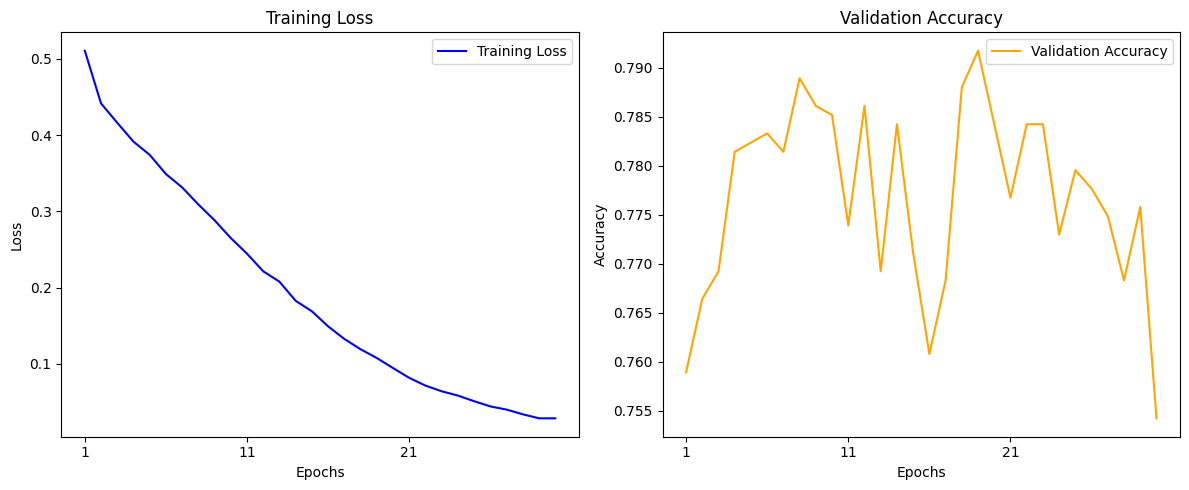

In [ ]:
plot_performance(train_losses, val_accuracies, len(train_losses))

# References

# **Handling OOV**

## **Load FastText Model**

In [ ]:
# Load the pre-trained Word2Vec model
if 'google.colab' in sys.modules:
    print("Running on Google Colab's hosted runtime")
    from google.colab import drive
    drive.mount('/content/drive')
    fasttext_model = load_facebook_model(PATH_TO_FASTTEXT_MODEL_DRIVE)
else:
    print("Running on a local runtime")
    fasttext_model = load_facebook_model(PATH_TO_FASTTEXT_MODEL_LOCAL)

# Get the dimension of the embeddings
fasttext_vector_dim = fasttext_model.vector_size
print(f"FastText Dimension: {fasttext_vector_dim}")

## **Preprocessing**

In [ ]:
X_train_OOV = preprocessed_train_dataset
Y_train_OOV = [entry['label'] for entry in train_dataset]

#X_val_OOV = drop_non_train_vocab(preprocessed_validation_dataset, lemmatized_vocabulary)
X_val_OOV = preprocessed_validation_dataset
Y_val_OOV = [entry['label'] for entry in validation_dataset]

#X_test_OOV = drop_non_train_vocab(preprocessed_test_dataset, lemmatized_vocabulary)
X_test_OOV = preprocessed_test_dataset
Y_test_OOV = [entry['label'] for entry in test_dataset]

def create_fasttext_embedding_matrix(fasttext_model, word2index, embedding_dim=300):
    vocab_size = len(word2index)  # Number of words in the training vocabulary

    # Initialize the embedding matrix with zeros (or any other value)
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

    for word, idx in word2index.items():
        embedding_matrix[idx] = fasttext_model.wv[word]

    return embedding_matrix

fasttext_embedding_dim = fasttext_model.vector_size  # Get the dimension of the word vectors in Word2Vec
fasttext_embedding_matrix = create_fasttext_embedding_matrix(fasttext_model, word2index, embedding_dim)
print(f"fasttext_embedding_matrix shape: {fasttext_embedding_matrix.shape}")

## **Seq2Seq + Padding**

In [ ]:
max_length_with_oov = get_max_sentence_length(X_train_OOV, X_val_OOV, X_test_OOV)
print(f"Maximum sentence length of three datasets: {max_length_with_oov}")

X_train_OOV_sequence = convert_to_sequence_data(X_train_OOV, word2index, max_length_with_oov)
X_val_OOV_sequence = convert_to_sequence_data(X_val_OOV , word2index, max_length_with_oov)
X_test_OOV_sequence = convert_to_sequence_data(X_test_OOV, word2index, max_length_with_oov)

print(f"Shape of X_train_OOV_sequence: {X_train_OOV_sequence.shape}")
print(f"Shape of X_val_OOV_sequence: {X_val_OOV_sequence.shape}")
print(f"Shape of X_test_OOV_sequence: {X_test_OOV_sequence.shape}")

#**BiLSTM - Word2Vec (MinPool - Unfreeze Embedding) - Normal**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation = "mean_pool",freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-10-26 05:27:51,546] Trial 27 finished with value: 0.7720450281425891 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.1, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'SGD'}. Best is trial 27 with value: 0.7720450281425891.

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 1 # Number of RNN layers choices
learning_rate = 0.1  # Learning rate choices
batch_size = 32  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'SGD'  # Optimizer choices
#[I 2024-10-26 05:27:51,546] Trial 27 finished with value: 0.7720450281425891 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.1, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'SGD'}. Best is trial 27 with value: 0.7720450281425891.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7702

In [ ]:
BILSTM_word2vec_MeanPool = 0.7702

#**BiLSTM - Word2Vec (MaxPool - Unfreeze Embedding) - Normal Embedding**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation = "max_pool",freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-10-26 04:55:48,552] Trial 25 finished with value: 0.7908067542213884 and parameters: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.1, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'SGD'}. Best is trial 25 with value: 0.7908067542213884.

In [ ]:
# The Best Hyperparameters
hidden_size = 64  # Hidden size choices
num_layers = 1 # Number of RNN layers choices
learning_rate = 0.1  # Learning rate choices
batch_size = 32  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'SGD'  # Optimizer choices
#[I 2024-10-26 04:55:48,552] Trial 25 finished with value: 0.7908067542213884 and parameters: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.1, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'SGD'}. Best is trial 25 with value: 0.7908067542213884.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='max_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7720

In [ ]:
BILSTM_word2vec_MaxPool = 0.7720

#**BiLSTM - Word2Vec (Last Hidden State - Unfreeze Embedding)**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-10-26 03:52:57,093] Trial 33 finished with value: 0.7842401500938087 and parameters: {'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'optimizer': 'RMSprop'}. Best is trial 33 with value: 0.7842401500938087.

In [ ]:
# The Best Hyperparameters
hidden_size = 256  # Hidden size choices
num_layers = 2 # Number of RNN layers choices
learning_rate = 0.001  # Learning rate choices
batch_size = 32  # Batch size choices
num_epochs = 10  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices
#[I 2024-10-25 15:00:47,380] Trial 16 finished with value: 0.7898686679174484 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.01, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.7898686679174484.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers)
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7889

Epoch [1/10], Train Loss: 0.6431, Validation Accuracy: 0.6144
Epoch [2/10], Train Loss: 0.5481, Validation Accuracy: 0.7523
Epoch [3/10], Train Loss: 0.4751, Validation Accuracy: 0.7598
Epoch [4/10], Train Loss: 0.4433, Validation Accuracy: 0.7720
Epoch [5/10], Train Loss: 0.4124, Validation Accuracy: 0.7777
Epoch [6/10], Train Loss: 0.3806, Validation Accuracy: 0.7711
Epoch [7/10], Train Loss: 0.3353, Validation Accuracy: 0.7899
Epoch [8/10], Train Loss: 0.2930, Validation Accuracy: 0.7805
Epoch [9/10], Train Loss: 0.2407, Validation Accuracy: 0.7702
Epoch [10/10], Train Loss: 0.1939, Validation Accuracy: 0.7824
Using Best Model, Test Accuracy: 0.7889


In [ ]:
BILSTM_word2vec_LHS = 0.7720

#**Load FastText Model**

In [ ]:
!pip install fasttext
import fasttext
from google.colab import drive
drive.mount('/content/drive')
fasttext_model = fasttext.load_model(PATH_TO_FASTTEXT_MODEL_DRIVE)
# # Load the pre-trained Word2Vec model
# if 'google.colab' in sys.modules:
#     print("Running on Google Colab's hosted runtime")
#     from google.colab import drive
#     drive.mount('/content/drive')
#     fasttext_model = load_facebook_model(PATH_TO_FASTTEXT_MODEL_DRIVE)
# else:
#     print("Running on a local runtime")
#     fasttext_model = load_facebook_model(PATH_TO_FASTTEXT_MODEL_LOCAL)

# # Get the dimension of the embeddings
# fasttext_vector_dim = fasttext_model.vector_size
# print(f"FastText Dimension: {fasttext_vector_dim}")

In [ ]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

# Dataset Preprocessing to tokenize and/or lemmatize
def preprocess_dataset(data, lemmatization = True):
    processed_sentences = []

    for entry in data:
        text = entry['text']
        # Tokenize the sentence
        tokens = word_tokenize(text)
        if lemmatization:
          # With case folding, punctuation and stop words removal
          tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in punctuation and word.lower() not in stop_words]

        processed_sentences.append(tokens)

    return processed_sentences

# Get vocab and oov words
def get_vocab_OOV(sentences, w2v_model):
    vocabulary = set()
    oov_words = set()

    for sentence in sentences:
        for word in sentence:
            vocabulary.add(word)
            if word not in w2v_model:
                oov_words.add(word)

    return vocabulary, oov_words

vocabulary, oov_words = get_vocab_OOV(preprocess_dataset(train_dataset, False), fasttext_model)
lemmatized_vocabulary, lemmatized_oov_words = get_vocab_OOV(preprocess_dataset(train_dataset), fasttext_model)

print(f"Before lemmatization: Vocabulary size: {len(vocabulary)}, OOV words: {len(oov_words)}")
print(f"After lemmatization: Vocabulary size: {len(lemmatized_vocabulary)}, OOV words: {len(lemmatized_oov_words)}")

In [ ]:
preprocessed_train_dataset = preprocess_dataset(train_dataset)
preprocessed_validation_dataset = preprocess_dataset(validation_dataset)
preprocessed_test_dataset = preprocess_dataset(test_dataset)

In [ ]:
def drop_oov(preprocessed_dataset, w2v_model):
    return [[word for word in sentence if word in w2v_model] for sentence in preprocessed_dataset]

def drop_non_train_vocab(dataset, train_vocab):
    return [[word for word in sentence if word in train_vocab] for sentence in dataset]

X_train = drop_oov(preprocessed_train_dataset, fasttext_model)
Y_train = [entry['label'] for entry in train_dataset]

X_val = drop_non_train_vocab(drop_oov(preprocessed_validation_dataset, fasttext_model), lemmatized_vocabulary)
Y_val = [entry['label'] for entry in validation_dataset]

X_test = drop_non_train_vocab(drop_oov(preprocessed_test_dataset, fasttext_model), lemmatized_vocabulary)
Y_test = [entry['label'] for entry in test_dataset]

In [ ]:
def get_word2index(train_vocab):
    word2index = {}
    for idx, word in enumerate(train_vocab):
        word2index[word] = idx + 1  # +1 to offset 0 for padding
    return word2index

word2index = get_word2index(lemmatized_vocabulary)

In [ ]:
def create_embedding_matrix(w2v_model, word2index, embedding_dim=300):
    """
    Creates an embedding matrix based on the word2index mapping and Word2Vec model.

    Args:
    - w2v_model: Pre-trained Word2Vec model.
    - word2index: Dictionary mapping words to their indices.
    - embedding_dim: Dimension of the Word2Vec word vectors (default: 300).

    Returns:
    - embedding_matrix: Embedding matrix where each row corresponds to the vector of a word in the vocabulary.
    """
    vocab_size = len(word2index)  # Number of words in the training vocabulary

    # Initialize the embedding matrix with zeros (or any other value)
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

    for word, idx in word2index.items():
        if word in w2v_model:
            # If the word exists in the Word2Vec model, use its pre-trained embedding
            embedding_matrix[idx] = w2v_model[word]
        else:
            # For out-of-vocabulary (OOV) words, initialize a random vector
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))

    return embedding_matrix

embedding_dim = fasttext_model.get_dimension()  # Get the dimension of the word vectors in Word2Vec
embedding_matrix = create_embedding_matrix(fasttext_model, word2index, embedding_dim)
print(f"embedding_matrix shape: {embedding_matrix.shape}")


In [ ]:
# Get maximum sentence length
def get_max_sentence_length(*datasets):
    """
    Get the maximum sentence length from the provided datasets.

    Args:
    - datasets: A variable number of lists containing tokenized sentences.

    Returns:
    - max_length: The maximum sentence length across all datasets.
    """
    max_length = 0
    for index, dataset in enumerate(datasets):
        # Update max_length if a longer sentence is found
        max_length = max(max_length, max(len(sentence) for sentence in dataset))
        min_length = min(len(sentence) for sentence in dataset)
        print(f"Min sentence length in dataset {index}: {min_length}")
    return max_length

# Example usage
max_length = get_max_sentence_length(X_train, X_val, X_test)
print(f"Maximum sentence length of three datasets: {max_length}")

In [ ]:
def convert_to_sequence_data(tokenized_data, word2index, max_length=max_length):
    """
    Preprocess the tokenized data for RNN input.

    Args:
    - tokenized_data: List of tokenized sentences.
    - word2index: Dictionary mapping words to indices.
    - max_length: Maximum length for padding (default is 100).

    Returns:
    - padded_sequences: Padded tensor of sequences.
    """
    # Convert tokens to indices
    indexed_sequences = []
    for sentence in tokenized_data:
        indexed_sentence = [word2index.get(word, 0) for word in sentence]  # Use 0 for OOV words

        # Truncate or pad the indexed sentence to the specified max_length
        if len(indexed_sentence) > max_length:
            indexed_sentence = indexed_sentence[:max_length]  # Truncate
        else:
            indexed_sentence += [0] * (max_length - len(indexed_sentence))  # Pad with zeros

        indexed_sequences.append(torch.tensor(indexed_sentence, dtype=torch.long))

    # Convert list of tensors to a padded tensor
    padded_sequences = torch.stack(indexed_sequences)

    return padded_sequences

# Convert to sequence
X_train_sequence = convert_to_sequence_data(X_train, word2index)
X_val_sequence = convert_to_sequence_data(X_val , word2index)
X_test_sequence = convert_to_sequence_data(X_test, word2index)

In [ ]:
import gc
del fasttext_model
gc.collect()


#**BiLSTM - FastText (MeanPool - Unfreeze Embedding)**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation = "mean_pool",freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-10-26 11:05:02,604] Trial 49 finished with value: 0.775797373358349 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.7823639774859287.

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 3 # Number of RNN layers choices
learning_rate = 1e-05  # Learning rate choices
batch_size = 128  # Batch size choices
num_epochs = 50  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices

#[I 2024-10-26 11:05:02,604] Trial 49 finished with value: 0.775797373358349 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.7823639774859287

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7486

Epoch [1/50], Train Loss: 0.6932, Validation Accuracy: 0.5000
Epoch [2/50], Train Loss: 0.6925, Validation Accuracy: 0.5000
Epoch [3/50], Train Loss: 0.6919, Validation Accuracy: 0.5253
Epoch [4/50], Train Loss: 0.6911, Validation Accuracy: 0.6370
Epoch [5/50], Train Loss: 0.6899, Validation Accuracy: 0.6407
Epoch [6/50], Train Loss: 0.6882, Validation Accuracy: 0.6482
Epoch [7/50], Train Loss: 0.6857, Validation Accuracy: 0.6454
Epoch [8/50], Train Loss: 0.6814, Validation Accuracy: 0.6463
Epoch [9/50], Train Loss: 0.6743, Validation Accuracy: 0.6520
Epoch [10/50], Train Loss: 0.6628, Validation Accuracy: 0.6689
Epoch [11/50], Train Loss: 0.6447, Validation Accuracy: 0.6604
Epoch [12/50], Train Loss: 0.6209, Validation Accuracy: 0.6651
Epoch [13/50], Train Loss: 0.5967, Validation Accuracy: 0.6745
Epoch [14/50], Train Loss: 0.5757, Validation Accuracy: 0.6839
Epoch [15/50], Train Loss: 0.5596, Validation Accuracy: 0.6998
Epoch [16/50], Train Loss: 0.5463, Validation Accuracy: 0.7036
E

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


In [ ]:
BILSTM_FT_MeanPool = 0.7486

#**BiLSTM - FastText (MaxPool - Unfreeze Embedding)**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation = "max_pool",freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-10-26 11:15:41,274] Trial 11 finished with value: 0.7842401500938087 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.7842401500938087.

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 2 # Number of RNN layers choices
learning_rate = 1e-05  # Learning rate choices
batch_size = 128  # Batch size choices
num_epochs = 40  # num epoch choices
optimizer_name = 'Adam'  # Optimizer choices
#[I 2024-10-26 11:15:41,274] Trial 11 finished with value: 0.7842401500938087 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.7842401500938087.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7336

In [ ]:
BILSTM_FT_MaxPool = 0.7336


#**BiLSTM - FastText (Last Hidden Sequence - Unfreeze Embedding)**

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
#[I 2024-10-26 12:21:30,570] Trial 3 finished with value: 0.7804878048780488 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 40, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7804878048780488.

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 3 # Number of RNN layers choices
learning_rate = 1e-05  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 40  # num epoch choices
optimizer_name = 'Adam'  # Optimizer choices
#[I 2024-10-26 12:21:30,570] Trial 3 finished with value: 0.7804878048780488 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 40, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.7804878048780488.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7486

In [ ]:
BILSTM_FT_LHS = 0.7486

#**Results (without OOV and stop words)**


In [ ]:

import pandas as pd

# Define data for each model type in a list of dictionaries
data = [
    {"Type": "BILSTM_FT_LHS", "Test Accuracy": BILSTM_FT_LHS},
    {"Type": "BILSTM_FT_MeanPool", "Test Accuracy": BILSTM_FT_MeanPool},
    {"Type": "BILSTM_FT_MaxPool", "Test Accuracy": BILSTM_FT_MaxPool},
    {"Type": "BILSTM_word2vec_LHS", "Test Accuracy": BILSTM_word2vec_LHS},
    {"Type": "BILSTM_word2vec_MeanPool", "Test Accuracy": BILSTM_word2vec_MeanPool},
    {"Type": "BILSTM_word2vec_MaxPool", "Test Accuracy": BILSTM_word2vec_MaxPool}
]

# Create the DataFrame directly from the list of dictionaries
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

#**Experiment 1 (OOV in train and with stop words)**


In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-10-27 12:44:01,078] Trial 3 finished with value: 0.7861163227016885 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 40, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 0.7861163227016885.

[I 2024-10-27 12:40:09,553] A new study created in memory with name: no-name-448ef0cf-c7d7-448c-9bae-d99df049cd88
[I 2024-10-27 12:40:17,786] Trial 0 finished with value: 0.7711069418386491 and parameters: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.7711069418386491.
[I 2024-10-27 12:42:28,171] Trial 1 finished with value: 0.7776735459662288 and parameters: {'hidden_size': 256, 'num_layers': 3, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.7776735459662288.
[I 2024-10-27 12:42:38,642] Trial 2 finished with value: 0.7401500938086304 and parameters: {'hidden_size': 64, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.7776735459662288.
[I 2024-10-27 12:44:01,078] Trial 3 finished with value: 0.7861163227016885 and parameters: {'hidden_size

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation="max_pool",freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-10-27 14:25:14,759] Trial 4 finished with value: 0.7954971857410882 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.7954971857410882.

[I 2024-10-27 14:21:52,042] A new study created in memory with name: no-name-7e8ac758-5df4-48c9-8e10-a8001f4acf61
[I 2024-10-27 14:22:22,133] Trial 0 finished with value: 0.5028142589118199 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 20, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5028142589118199.
[I 2024-10-27 14:23:37,992] Trial 1 finished with value: 0.7682926829268293 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 40, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.7682926829268293.
[I 2024-10-27 14:24:04,407] Trial 2 finished with value: 0.774859287054409 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.774859287054409.
[I 2024-10-27 14:24:18,007] Trial 3 finished with value: 0.49906191369606 and parameters: {'hidden_size': 256

In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation="mean_pool",freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
#[I 2024-10-27 15:15:17,805] Trial 1 finished with value: 0.7945590994371482 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7945590994371482.

[I 2024-10-27 15:13:54,631] A new study created in memory with name: no-name-98285b3e-504f-40d5-9555-a177a97e67d7
[I 2024-10-27 15:14:16,145] Trial 0 finished with value: 0.7814258911819888 and parameters: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 0.1, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.7814258911819888.
[I 2024-10-27 15:15:17,805] Trial 1 finished with value: 0.7945590994371482 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7945590994371482.
[I 2024-10-27 15:15:45,190] Trial 2 finished with value: 0.5 and parameters: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 0.1, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7945590994371482.
[I 2024-10-27 15:16:00,758] Trial 3 finished with value: 0.6097560975609756 and parameters: {'hidden_size': 128, 'num_lay

#Statistical Average

In [ ]:

#X_train = drop_oov(preprocessed_train_dataset, w2v_model)
X_train = preprocessed_train_dataset
Y_train = [entry['label'] for entry in train_dataset]

#X_val = drop_non_train_vocab(drop_oov(preprocessed_validation_dataset, w2v_model), lemmatized_vocabulary)
X_val = drop_non_train_vocab(preprocessed_validation_dataset, lemmatized_vocabulary)
Y_val = [entry['label'] for entry in validation_dataset]

#X_test = drop_non_train_vocab(drop_oov(preprocessed_test_dataset, w2v_model), lemmatized_vocabulary)
X_test = drop_non_train_vocab(preprocessed_test_dataset, lemmatized_vocabulary)
Y_test = [entry['label'] for entry in test_dataset]


In [ ]:
def create_embedding_matrix(w2v_model, word2index, embedding_dim=300):
    """
    Creates an embedding matrix based on the word2index mapping and Word2Vec model.

    Args:
    - w2v_model: Pre-trained Word2Vec model.
    - word2index: Dictionary mapping words to their indices.
    - embedding_dim: Dimension of the Word2Vec word vectors (default: 300).

    Returns:
    - embedding_matrix: Embedding matrix where each row corresponds to the vector of a word in the vocabulary.
    """
    vocab_size = len(word2index)  # Number of words in the training vocabulary

    # Initialize the embedding matrix with zeros (or any other value)
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
    num_oov = 0

    for word, idx in word2index.items():
        if word in w2v_model:
            # If the word exists in the Word2Vec model, use its pre-trained embedding
            embedding_matrix[idx] = w2v_model[word]
        else:
            num_oov += 1

    avg_embedding = np.mean(embedding_matrix[np.nonzero(embedding_matrix)], axis=0)

    # Assign average embedding to OOV words
    for word, idx in word2index.items():
        if embedding_matrix[idx].sum() == 0:  # Check if embedding is all zeros
            embedding_matrix[idx] = avg_embedding


    return embedding_matrix

embedding_dim = w2v_model.vector_size  # Get the dimension of the word vectors in Word2Vec
embedding_matrix = create_embedding_matrix(w2v_model, word2index, embedding_dim)
print(f"embedding_matrix shape: {embedding_matrix.shape}")

embedding_matrix shape: (16566, 300)


In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation="max_pool",freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


[I 2024-10-29 01:33:59,187] A new study created in memory with name: no-name-00ea7faf-212d-42cf-802c-53d965c3a944
[W 2024-10-29 01:34:02,063] Trial 0 failed with parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 40, 'optimizer': 'RMSprop'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-28-a7714a43bc85>", line 29, in objective
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)
  File "<ipython-input-4-3e3d26fd2c5d>", line 48, in optimizer_factory
    return torch.optim.RMSprop(model.parameters(), lr = learning_rate)
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/rmsprop.py", line 68, in __init__
    super().__init__(params, defaults)
  File "/usr/local/lib/python3.10/dist-packages/torch/optim/optimizer.p

KeyboardInterrupt: 

#BiLSTM with Residual Connections

In [ ]:
class SimpleBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, aggregation='last_hidden_state', freeze_embedding=True):
        super(SimpleBiLSTM, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.aggregation = aggregation
        self.hidden_size = hidden_size  # Store hidden size for reference

        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=0,  # Using 0 for padding index
            freeze=freeze_embedding,  # Freeze embeddings
        )

        self.residual_projection = nn.Linear(embedding_dim, hidden_size * 2)

        # BiLSTM layer with bidirectional=True
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.1)

        # Output layer dimensions adjusted for bidirectional LSTM (2 * hidden_size)
        self.fc = nn.Linear(4 * hidden_size, 1)  # Adjusted output size for concatenated max and mean pooling

    def forward(self, x):
        # Pass through the embedding layer
        embedded = self.embedding(x)

        # Initialize hidden and cell states for both directions (2*num_layers for bidirectional)
        h0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)
        c0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)

        # Forward pass through BiLSTM
        out, (hn, cn) = self.lstm(embedded, (h0, c0))

        # Apply residual connection
        residual = self.residual_projection(embedded)  # Project embeddings to match 'out' dimensions
        out = out + residual  # Add residual connection

        # Aggregation method
        if self.aggregation == 'last_hidden_state':
            # Concatenate the last hidden states from both directions
            out = torch.cat((hn[-2], hn[-1]), dim=1)  # -2 and -1 refer to the last forward and backward states
        elif self.aggregation == 'max_mean_pool':
            # Mask out padding tokens for pooling
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)

            # Max pooling
            max_pooled_out = out.masked_fill(~mask, -100000)  # Mask padding tokens with a large negative value
            max_pooled_out, _ = torch.max(max_pooled_out, dim=1)

            # Mean pooling
            mean_pooled_out = out * mask
            summed = mean_pooled_out.sum(dim=1)
            valid_counts = mask.sum(dim=1).clamp(min=1)
            mean_pooled_out = summed / valid_counts

            # Concatenate max and mean pooling outputs
            out = torch.cat((max_pooled_out, mean_pooled_out), dim=1)

        out = self.dropout(out)  # Apply dropout
        out = self.fc(out)  # Final fully connected layer

        # Sigmoid activation for binary classification
        out = torch.sigmoid(out)

        return out


In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers,aggregation='max_mean_pool',freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-11-01 13:40:54,131] Trial 10 finished with value: 0.7964352720450282 and parameters: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7964352720450282.


[I 2024-11-03 06:46:06,350] A new study created in memory with name: no-name-6b63c27b-bc5e-41be-8c66-62bf4779e918
[I 2024-11-03 06:47:03,319] Trial 0 finished with value: 0.7317073170731707 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.7317073170731707.
[I 2024-11-03 06:50:43,869] Trial 1 finished with value: 0.7908067542213884 and parameters: {'hidden_size': 256, 'num_layers': 3, 'learning_rate': 0.1, 'batch_size': 128, 'num_epochs': 50, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.7908067542213884.
[I 2024-11-03 06:51:22,876] Trial 2 finished with value: 0.7879924953095685 and parameters: {'hidden_size': 128, 'num_layers': 1, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 40, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.7908067542213884.
[I 2024-11-03 06:52:25,462] Trial 3 finished with value: 0.7664165103189493 and parameters: {'hidden_size': 128

In [ ]:
# The Best Hyperparameters
hidden_size = 64  # Hidden size choices
num_layers = 3 # Number of RNN layers choices
learning_rate = 1e-05  # Learning rate choices
batch_size = 32  # Batch size choices
num_epochs = 60  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices


# [I 2024-11-01 13:40:54,131] Trial 10 finished with value: 0.7964352720450282 and parameters: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.7964352720450282.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='max_mean_pool')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7833

Epoch [1/60], Train Loss: 0.6926, Validation Accuracy: 0.5291
Epoch [2/60], Train Loss: 0.6886, Validation Accuracy: 0.5976
Epoch [3/60], Train Loss: 0.6856, Validation Accuracy: 0.6576
Epoch [4/60], Train Loss: 0.6823, Validation Accuracy: 0.6782
Epoch [5/60], Train Loss: 0.6781, Validation Accuracy: 0.6820
Epoch [6/60], Train Loss: 0.6737, Validation Accuracy: 0.7036
Epoch [7/60], Train Loss: 0.6671, Validation Accuracy: 0.7158
Epoch [8/60], Train Loss: 0.6577, Validation Accuracy: 0.6932
Epoch [9/60], Train Loss: 0.6417, Validation Accuracy: 0.7101
Epoch [10/60], Train Loss: 0.6137, Validation Accuracy: 0.7054
Epoch [11/60], Train Loss: 0.5767, Validation Accuracy: 0.7158
Epoch [12/60], Train Loss: 0.5484, Validation Accuracy: 0.7214
Epoch [13/60], Train Loss: 0.5340, Validation Accuracy: 0.7139
Epoch [14/60], Train Loss: 0.5238, Validation Accuracy: 0.7317
Epoch [15/60], Train Loss: 0.5157, Validation Accuracy: 0.7326
Epoch [16/60], Train Loss: 0.5099, Validation Accuracy: 0.7420
E

# **MHSA (Mean Pooling)**

In [ ]:
import torch
import torch.nn as nn

class SimpleBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, num_attention_heads=8, aggregation='last_hidden_state', freeze_embedding=True):
        super(SimpleBiLSTM, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.aggregation = aggregation
        self.hidden_size = hidden_size  # Store hidden size for reference

        # Ensure num_attention_heads is compatible with embedding_dim
        if embedding_dim % num_attention_heads != 0:
            num_attention_heads = max(1, embedding_dim // 64)  # Adjust to nearest factor if needed
            #print(f"Adjusted num_attention_heads to {num_attention_heads} for compatibility with embedding_dim {embedding_dim}.")


        # Embedding layer using a pretrained embedding matrix
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=0,  # Using 0 for padding index
            freeze=freeze_embedding,  # Freeze embeddings
        )

        # Multi-head self-attention layer
        self.mhsa = nn.MultiheadAttention(embedding_dim, num_attention_heads, batch_first=True)

        # BiLSTM layer with bidirectional=True
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)

        # Output layer dimensions adjusted for bidirectional LSTM (2 * hidden_size)
        self.fc = nn.Linear(300, 1)

    def forward(self, x):
        # Pass through the embedding layer
        embedded = self.embedding(x)

        # Create padding mask for the attention layer
        device = embedded.device
        padding_mask_final = torch.zeros(x.size(0), x.size(1), dtype=torch.bool, device=device)
        padding_mask = (x[:, 1:] == self.embedding.padding_idx)
        padding_mask_final[:, 1:] = padding_mask

        # Apply multi-head self-attention
        attention_out, _ = self.mhsa(embedded, embedded, embedded, key_padding_mask=padding_mask_final)

        # Forward pass through BiLSTM using attention output as input
        h0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)
        c0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)
        lstm_out, (hn, cn) = self.lstm(attention_out, (h0, c0))

        # Aggregation method
        if self.aggregation == 'last_hidden_state':
            # Concatenate the last hidden states from both directions
            out = torch.cat((hn[-2], hn[-1]), dim=1)  # -2 and -1 refer to the last forward and backward states
        elif self.aggregation == 'max_mean_pool':
            # Mask out padding tokens for pooling
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)

            # Max pooling
            max_pooled_out = lstm_out.masked_fill(~mask, -100000)  # Mask padding tokens with a large negative value
            max_pooled_out, _ = torch.max(max_pooled_out, dim=1)

            # Mean pooling
            mean_pooled_out = lstm_out * mask
            summed = mean_pooled_out.sum(dim=1)
            valid_counts = mask.sum(dim=1).clamp(min=1)
            mean_pooled_out = summed / valid_counts

            # Concatenate max and mean pooling outputs
            out = torch.cat((max_pooled_out, mean_pooled_out), dim=1)
        elif self.aggregation == 'mhsa':

            # Mean pooling on the output of MHSA layer
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            attention_out = attention_out * mask
            summed = attention_out.sum(dim=1)
            valid_counts = mask.sum(dim=1).clamp(min=1)
            out = summed / valid_counts

        out = self.dropout(out)  # Apply dropout
        #print(f"Dimension before fully connected layer: {out.shape}")
        out = self.fc(out)  # Final fully connected layer

        # Sigmoid activation for binary classification
        out = torch.sigmoid(out)

        return out


In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):
    # Reset the seed for fairness
    torch.manual_seed(42)
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers,aggregation='mhsa',freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

#[I 2024-11-01 11:48:03,237] Trial 38 finished with value: 0.7954971857410882 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 40, 'optimizer': 'RMSprop'}. Best is trial 38 with value: 0.7954971857410882.

[I 2024-11-01 11:06:01,234] A new study created in memory with name: no-name-9650c122-8dc0-452d-8d6a-fbb253287375
[I 2024-11-01 11:06:36,935] Trial 0 finished with value: 0.773921200750469 and parameters: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 30, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.773921200750469.
[I 2024-11-01 11:08:09,101] Trial 1 finished with value: 0.7814258911819888 and parameters: {'hidden_size': 256, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.7814258911819888.
[I 2024-11-01 11:09:37,715] Trial 2 finished with value: 0.7823639774859287 and parameters: {'hidden_size': 64, 'num_layers': 3, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.7823639774859287.
[I 2024-11-01 11:10:40,990] Trial 3 finished with value: 0.7851782363977486 and parameters: {'hidden_size

In [ ]:
# The Best Hyperparameters
hidden_size = 128  # Hidden size choices
num_layers = 3 # Number of RNN layers choices
learning_rate = 0.0001  # Learning rate choices
batch_size = 128  # Batch size choices
num_epochs = 40  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices


#[I 2024-11-01 11:48:03,237] Trial 38 finished with value: 0.7954971857410882 and parameters: {'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 40, 'optimizer': 'RMSprop'}. Best is trial 38 with value: 0.7954971857410882.

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='mhsa')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7795

Epoch [1/40], Train Loss: 0.6238, Validation Accuracy: 0.7355
Epoch [2/40], Train Loss: 0.5073, Validation Accuracy: 0.7523
Epoch [3/40], Train Loss: 0.4767, Validation Accuracy: 0.7542
Epoch [4/40], Train Loss: 0.4669, Validation Accuracy: 0.7674
Epoch [5/40], Train Loss: 0.4610, Validation Accuracy: 0.7749
Epoch [6/40], Train Loss: 0.4572, Validation Accuracy: 0.7542
Epoch [7/40], Train Loss: 0.4526, Validation Accuracy: 0.7570
Epoch [8/40], Train Loss: 0.4499, Validation Accuracy: 0.7749
Epoch [9/40], Train Loss: 0.4468, Validation Accuracy: 0.7608
Epoch [10/40], Train Loss: 0.4435, Validation Accuracy: 0.7645
Epoch [11/40], Train Loss: 0.4425, Validation Accuracy: 0.7739
Epoch [12/40], Train Loss: 0.4390, Validation Accuracy: 0.7683
Epoch [13/40], Train Loss: 0.4365, Validation Accuracy: 0.7692
Epoch [14/40], Train Loss: 0.4360, Validation Accuracy: 0.7683
Epoch [15/40], Train Loss: 0.4341, Validation Accuracy: 0.7739
Epoch [16/40], Train Loss: 0.4315, Validation Accuracy: 0.7702
E

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


# Attention

In [ ]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention_weights = nn.Linear(hidden_size * 2, 1, bias=False)  # *2 for bidirectional LSTM

    def forward(self, lstm_out):
        # lstm_out shape: (batch_size, seq_len, hidden_size * 2)

        # Compute attention scores
        attn_scores = self.attention_weights(lstm_out)  # (batch_size, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # Softmax over seq_len dimension

        # Compute context vector as weighted sum of lstm_out
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)  # (batch_size, hidden_size * 2)

        return context_vector


class SimpleBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, aggregation='last_hidden_state', freeze_embedding=True):
        super(SimpleBiLSTM, self).__init__()
        embedding_dim = embedding_matrix.shape[1]

        self.aggregation = aggregation
        self.hidden_size = hidden_size

        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            padding_idx=0,
            freeze=freeze_embedding,
        )

        # BiLSTM layer with bidirectional=True
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Attention layer (optional, if needed)
        self.attention = Attention(hidden_size) if aggregation == 'attention' else None

        # Batch normalization layers
        self.batch_norm_lstm = nn.BatchNorm1d(hidden_size * 2)  # For BiLSTM output (bidirectional)

        # Set batch normalization for fully connected layer based on aggregation method
        if aggregation == 'max_mean_pool':
            self.batch_norm_fc = nn.BatchNorm1d(hidden_size * 4)  # For concatenated max and mean pooling
            self.fc = nn.Linear(hidden_size * 4, 1)  # Adjusted output size for concatenated max and mean pooling
        else:
            self.batch_norm_fc = nn.BatchNorm1d(hidden_size * 2)
            self.fc = nn.Linear(hidden_size * 2, 1)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        embedded = self.embedding(x)

        # Initialize hidden and cell states for BiLSTM
        h0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)
        c0 = torch.zeros(2 * self.lstm.num_layers, embedded.size(0), self.hidden_size).to(embedded.device)

        # Forward pass through BiLSTM
        out, (hn, cn) = self.lstm(embedded, (h0, c0))
        out = self.batch_norm_lstm(out.transpose(1, 2)).transpose(1, 2)

        # Aggregation
        if self.aggregation == 'last_hidden_state':
            out = torch.cat((hn[-2], hn[-1]), dim=1)
        elif self.aggregation == 'max_mean_pool':
            mask = (x != self.embedding.padding_idx).unsqueeze(-1)
            max_pooled_out = out.masked_fill(~mask, -1e9).max(dim=1).values
            mean_pooled_out = out.sum(dim=1) / mask.sum(dim=1).clamp(min=1)
            out = torch.cat((max_pooled_out, mean_pooled_out), dim=1)
        elif self.aggregation == 'attention':
            out = self.attention(out)

        # Apply batch normalization before the fully connected layer
        out = self.batch_norm_fc(out)

        # Dropout and final fully connected layer
        out = self.dropout(out)
        out = self.fc(out).squeeze(1)

        # Sigmoid activation for binary classification
        out = torch.sigmoid(out)

        return out


In [ ]:
import optuna
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# Define the objective function for Optuna
def objective(trial):

    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    # Hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_categorical('num_epochs', [30, 40, 50])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Create data loaders
    train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)
    # Initialize the model
    model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers,aggregation='attention',freeze_embedding=False).to(device)
    criterion = nn.BCELoss()  # Use BCELoss for binary classification

    # Choose optimizer based on trial suggestion
    optimizer = optimizer_factory(optimizer_name, model, learning_rate)

    # Evaluation function
    def evaluate_model(data_loader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                outputs = model(inputs)
                predicted = (outputs.squeeze() > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels.float()).sum().item()
        accuracy = correct / total
        return accuracy

    # Training Loop
    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_accuracy = evaluate_model(val_loader)
        if val_accuracy > max_accuracy:
            max_accuracy = val_accuracy

    # Return the validation accuracy as the objective value to optimize
    return max_accuracy

# Start the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


[I 2024-11-02 11:36:17,774] A new study created in memory with name: no-name-efe1c6eb-c5fc-4896-aa1a-b1d449d8f6ae
[I 2024-11-02 11:37:20,088] Trial 0 finished with value: 0.6529080675422139 and parameters: {'hidden_size': 64, 'num_layers': 2, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 40, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.6529080675422139.
[I 2024-11-02 11:38:20,904] Trial 1 finished with value: 0.5 and parameters: {'hidden_size': 128, 'num_layers': 2, 'learning_rate': 0.1, 'batch_size': 64, 'num_epochs': 40, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.6529080675422139.
[I 2024-11-02 11:42:49,226] Trial 2 finished with value: 0.5028142589118199 and parameters: {'hidden_size': 256, 'num_layers': 3, 'learning_rate': 0.1, 'batch_size': 32, 'num_epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.6529080675422139.
[I 2024-11-02 11:47:03,151] Trial 3 finished with value: 0.7363977485928705 and parameters: {'hidden_size': 256, 'num_lay

In [ ]:
#[I 2024-11-02 12:25:14,771] Trial 35 finished with value: 0.8067542213883677 and parameters: {'hidden_size': 256, 'num_layers': 1, 'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 30, 'optimizer': 'RMSprop'}. Best is trial 35 with value: 0.8067542213883677.
# The Best Hyperparameters
hidden_size = 256  # Hidden size choices
num_layers = 1 # Number of RNN layers choices
learning_rate = 1e-05  # Learning rate choices
batch_size = 64  # Batch size choices
num_epochs = 30  # num epoch choices
optimizer_name = 'RMSprop'  # Optimizer choices



In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device)

# Initialize the model
model = SimpleBiLSTM(embedding_matrix, hidden_size, num_layers, aggregation='attention')
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = optimizer_factory(optimizer_name, model, learning_rate)
# Initialize the early stopper
early_stopper = EarlyStopper()

# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_model = copy.deepcopy(model)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if early_stopper.early_stop(val_accuracy):
       print("Early stopping triggered!")
       break

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}") #0.7964

Epoch [1/30], Train Loss: 0.6503, Validation Accuracy: 0.6839
Epoch [2/30], Train Loss: 0.5733, Validation Accuracy: 0.7270
Epoch [3/30], Train Loss: 0.5324, Validation Accuracy: 0.7402
Epoch [4/30], Train Loss: 0.5123, Validation Accuracy: 0.7448
Epoch [5/30], Train Loss: 0.4927, Validation Accuracy: 0.7467
Epoch [6/30], Train Loss: 0.4829, Validation Accuracy: 0.7514
Epoch [7/30], Train Loss: 0.4762, Validation Accuracy: 0.7580
Epoch [8/30], Train Loss: 0.4705, Validation Accuracy: 0.7552
Epoch [9/30], Train Loss: 0.4618, Validation Accuracy: 0.7561
Epoch [10/30], Train Loss: 0.4537, Validation Accuracy: 0.7589
Epoch [11/30], Train Loss: 0.4469, Validation Accuracy: 0.7636
Epoch [12/30], Train Loss: 0.4417, Validation Accuracy: 0.7627
Epoch [13/30], Train Loss: 0.4368, Validation Accuracy: 0.7627
Epoch [14/30], Train Loss: 0.4336, Validation Accuracy: 0.7636
Epoch [15/30], Train Loss: 0.4279, Validation Accuracy: 0.7636
Epoch [16/30], Train Loss: 0.4249, Validation Accuracy: 0.7692
E

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


# Simple Embedding Matrix Method

In [ ]:
def create_embedding_matrix(w2v_model, word2index, embedding_dim=300):
    """
    Creates an embedding matrix based on the word2index mapping and Word2Vec model.

    Args:
    - w2v_model: Pre-trained Word2Vec model.
    - word2index: Dictionary mapping words to their indices.
    - embedding_dim: Dimension of the Word2Vec word vectors (default: 300).

    Returns:
    - embedding_matrix: Embedding matrix where each row corresponds to the vector of a word in the vocabulary.
    """
    vocab_size = len(word2index)  # Number of words in the training vocabulary

    # Initialize the embedding matrix with zeros (or any other value)
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

    for word, idx in word2index.items():
        if word in w2v_model:
            # If the word exists in the Word2Vec model, use its pre-trained embedding
            embedding_matrix[idx] = w2v_model[word]
        else:
            # For out-of-vocabulary (OOV) words, initialize a random vector
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))

    return embedding_matrix

embedding_dim = w2v_model.vector_size  # Get the dimension of the word vectors in Word2Vec
embedding_matrix = create_embedding_matrix(w2v_model, word2index, embedding_dim)
print(f"embedding_matrix shape: {embedding_matrix.shape}")